# Homeworks 3, 4

Student: Grigoryev Mikhail

Group: J4133c

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import time

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
def generateConsts(dynamic=True, min_workers=4, max_workers=10):
    constants = [
        "package main",
        "",
        "const (",
        "\tWORKTIME int = 100",
        "\tARRIVETIME int = 5",
        "\tCUSTOMERS int = 500",
        f"\tMINWORKERS int = {min_workers}",
        f"\tMAXWORKERS int = {max_workers}",
        "\tMAXCHILL float64 = 5",
        f"\tDYNAMIC bool = {'true' if dynamic else 'false'}",
        ")"
    ]
    with open("./constants.go", "w") as f:
        f.writelines(line+'\n' for line in constants)

In [3]:
print(os.getcwd())
os.chdir("./q")

/home/dormant/discrete-mm


Looking at CSV structure:

In [4]:
generateConsts()
os.system("go run .")
df_cli = pd.read_csv(f"./logs/clients_dynamic_true_4.csv")
df_serv = pd.read_csv(f"./logs/servers_dynamic_true_4.csv")

In [5]:
df_cli.tail()

,Customer,Cashier,Created,ArrivedQueue,ArrivedCashier,Left,PeopleBefore
495,497,6,1686050658097,1686050659285,1686050660805,1686050660815,26
496,499,1,1686050658097,1686050659287,1686050660740,1686050660825,26
497,481,3,1686050658097,1686050659242,1686050660793,1686050660879,25
498,490,3,1686050658097,1686050659270,1686050660879,1686050660957,25
499,494,3,1686050658097,1686050659276,1686050660957,1686050660977,25


In [6]:
df_serv[df_serv["Server"] == 1].head(10)

,Server,Action,Time
0,1,CREATED,1686050658097
28,1,STARTED,1686050658106
29,1,FINISHED,1686050658184
32,1,STARTED,1686050658184
33,1,FINISHED,1686050658194
52,1,STARTED,1686050658194
53,1,FINISHED,1686050658231
84,1,STARTED,1686050658231
85,1,FINISHED,1686050658319
108,1,STARTED,1686050658319


In [7]:
def getMetrics(dyn=True, minw=4, maxw=10):
    start_time = time.time()
    generateConsts(dyn, minw, maxw)
    os.system("go run .")
    df_cli = pd.read_csv(f"./logs/clients_dynamic_{'true' if dyn else 'false'}_{minw}.csv")
    df_serv = pd.read_csv(f"./logs/servers_dynamic_{'true' if dyn else 'false'}_{minw}.csv")
    
    metrics = {}
    waiters = df_cli[df_cli["ArrivedCashier"] - df_cli["ArrivedQueue"] > 0]
    metrics["avg_wait_time"] = (df_cli["ArrivedCashier"] - df_cli["ArrivedQueue"]).mean()
    metrics["prob_wait"] = len(waiters) / len(df_cli)
    metrics["avg_service_time"] = (df_cli["Left"] - df_cli["ArrivedCashier"]).mean()
    metrics["avg_wait_time_waiters"] = (
        waiters["ArrivedCashier"] - waiters["ArrivedQueue"]
    ).mean()
    metrics["avg_sys_time"] = (df_cli["Left"] - df_cli["ArrivedQueue"]).mean()
    
    arrivals = []
    idles = []
    works = []
    
    for i in range(maxw):
        cur_cli = df_cli[df_cli["Cashier"] == i]
        cur_serv = df_serv[df_serv["Server"] == i]
        
        if len(cur_cli) == 0:
            continue
        
        arrivals.append(cur_cli.diff()["ArrivedCashier"].mean())
        
        to_drop = [idx for idx in cur_serv.index[cur_serv["Action"] == "DELETED"]]
        to_drop.extend([idx+1 for idx in to_drop])
        cur_serv.drop(to_drop, inplace=True)
        # left with created-started-finished-started-finished-...-finished
        #            odd[0]-even[0]- odd[1] -even[1]- odd[2] -...- odd[n]
        odd_serv = cur_serv.iloc[::2]["Time"].to_numpy()
        even_serv = cur_serv.iloc[1::2]["Time"].to_numpy()
        assert len(odd_serv) == len(even_serv)+1, "Server logs even after deleting DELETE-CREATE pairs"
        idle = (even_serv-odd_serv[:-1]).sum()
        work = (odd_serv[1:]-even_serv).sum()
        idles.append(idle)
        works.append(work)
        
    metrics["avg_time_arrivals"] = np.array(arrivals).mean()
    metrics["prob_idle"] = np.array(idles).sum() / (np.array(idles).sum() + np.array(works).sum())
    end_time = time.time()
    #print(f"{end_time - start_time :.2f} s")
    return metrics

In [8]:
print(getMetrics(True, 1))

2.88 s
{'avg_wait_time': 672.866, 'prob_wait': 0.984, 'avg_service_time': 50.67, 'avg_wait_time_waiters': 683.8069105691056, 'avg_sys_time': 723.536, 'avg_time_arrivals': 50.83884537759458, 'prob_idle': 0.0019696671262556626}


In [9]:
dyn = True
minw = 4

cols = list(getMetrics(dyn, minw).keys())
metrics_df = pd.DataFrame(columns=cols)
for i in range(10):
    metrics = getMetrics(dyn, minw)
    metrics_df = metrics_df.append(metrics, ignore_index=True)
    
metrics_df.to_csv(f"../HW4/metrics_HW4_{dyn}_{minw}.csv", index=False)
metrics_df.head()

2.79 s
3.00 s
2.86 s
3.04 s
2.72 s
2.94 s
2.93 s
3.23 s
2.84 s
2.69 s
2.94 s


,avg_wait_time,prob_wait,avg_service_time,avg_wait_time_waiters,avg_sys_time,avg_time_arrivals,prob_idle
0,676.980,0.982,50.872,689.389002,727.852,51.294079,0.002666
1,708.158,0.980,51.208,722.610204,759.366,51.211249,0.001482
2,708.714,0.982,50.710,721.704684,759.424,51.125263,0.001772
3,595.204,0.980,48.212,607.351020,643.416,48.396938,0.003390
4,661.246,0.976,51.350,677.506148,712.596,51.408561,0.003106


Lab 3

Comparison by average queue size, total working etc. Draw server's dynamic through the time (for dynamic queues).

## Lab 3

In [10]:
def compareQueues(dyn=True, minw=4):
    start_time = time.time()
    generateConsts(dyn, minw)
    os.system("go run .")
    end_time = time.time()
    df_cli = pd.read_csv(f"./logs/clients_dynamic_{'true' if dyn else 'false'}_{minw}.csv")
    #df_serv = pd.read_csv(f"./logs/servers_dynamic_{'true' if dyn else 'false'}_{minw}.csv")
    print(f"\n{'Dynamic' if dyn else 'Static'} {'general' if minw==1 else 'shortest'}")
    print(f"Elapsed runtime: {end_time - start_time :.2f} s")
    avg_q = df_cli["PeopleBefore"].mean()
    print(f"Average queue length: {avg_q :.2f}")

In [11]:
for d in [False, True]:
    for m in [1, 4]:
        compareQueues(d, m)


Static general
Elapsed runtime: 25.69 s
Average queue length: 238.98

Static shortest
Elapsed runtime: 6.88 s
Average queue length: 50.61

Dynamic general
Elapsed runtime: 2.87 s
Average queue length: 13.81

Dynamic shortest
Elapsed runtime: 2.81 s
Average queue length: 13.64


In [21]:
def plotDynamic(minw=4):
    generateConsts(True, minw)
    os.system("go run .")
    #df_cli = pd.read_csv(f"./logs/clients_dynamic_{'true' if dyn else 'false'}_{minw}.csv")
    df_serv = pd.read_csv(f"./logs/servers_dynamic_{'true' if dyn else 'false'}_{minw}.csv")
    start = df_serv.iloc[0]["Time"]
    end = df_serv.iloc[-1]["Time"]
    df_serv = df_serv[df_serv["Action"].isin(["CREATED", "DELETED"])]
    df_serv["CountCreate"] = (df_serv["Action"] == "CREATED").cumsum()
    df_serv["DeleteCount"] = (df_serv["Action"] == "DELETED").cumsum()
    df_serv["Count"] = df_serv["CountCreate"] - df_serv["DeleteCount"]
    
    X = list(df_serv["Time"])
    X.append(end)
    X = [item-start for item in X]
    X = np.array(X)
    
    Y = list(df_serv["Count"])
    Y.append(Y[-1])
    Y = np.array(Y)
    
    plt.subplot(2, 1, 1)
    plt.plot(X, Y)
    plt.title(f"{'General' if minw==1 else 'Shortest'}")
    plt.xlim((0, end-start))
    
    plt.subplot(2, 1, 2)
    plt.plot(X, Y)
    plt.xlim((0, (end-start)/20))
    plt.xlabel("Timestamp, ms")
    plt.ylabel("Servers active")

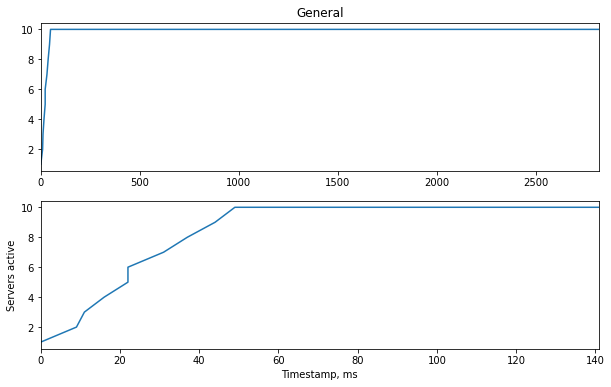

In [22]:
plotDynamic(1)

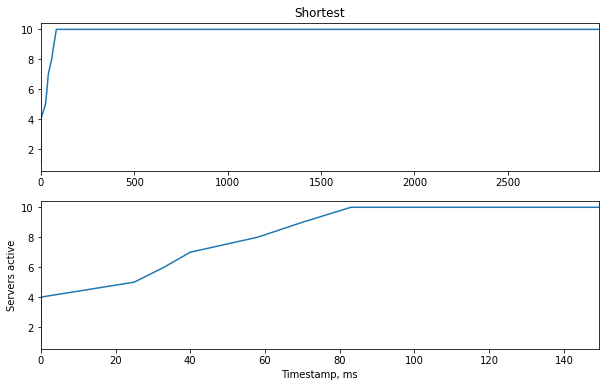

In [23]:
plotDynamic(4)

Lab 4

Make several test runs and estimate sufficient number of replications to achieve the specified accuracy. If the accuracy is not achieved, repeat the procedure again. Computational technology is on your own decision.

## Lab 4

In [24]:
def exportMetrics(dyn=True, minw=4, n=10):
    cols = list(getMetrics(dyn, minw).keys())
    metrics_df = pd.DataFrame(columns=cols)
    for i in range(n):
        metrics = getMetrics(dyn, minw)
        metrics_df = metrics_df.append(metrics, ignore_index=True)
    metrics_df.to_csv(f"../HW4/metrics_HW4_{dyn}_{minw}_{n}.csv", index=False)

In [25]:
n = 500
for d in [False, True]:
    for m in [1, 4]:
        exportMetrics(d, m, n)

25.11 s
25.76 s
23.00 s
25.21 s
6.84 s
6.63 s
6.72 s
6.77 s
2.79 s
2.85 s
3.02 s
2.97 s
3.07 s
2.87 s
2.81 s
2.71 s


In [28]:
df = pd.read_csv(f"../HW4/metrics_HW4_False_4_{n}.csv")
df.head()

,avg_wait_time,prob_wait,avg_service_time,avg_wait_time_waiters,avg_sys_time,avg_time_arrivals,prob_idle
0,2594.276,0.992,50.666,2615.197581,2644.942,50.800207,0.002834
1,2585.668,0.992,50.824,2606.520161,2636.492,50.840861,0.002316
2,2554.434,0.992,50.306,2575.034274,2604.740,50.377016,0.003052
